## Programming Exercise 7: K-means Clustering（聚合）and Principal Component Analysis（主成分分析）

In [118]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
from random import sample #Used for random initialization

from PIL import Image #Used to show matrix as an image
import imageio # used to read image
import matplotlib.cm as cm #Used to display images in a specific colormap

from scipy import linalg #Used for the "SVD" function

#### 1 K-means Clustering 

##### 1.1 Implementing K-means 

##### 1.1.1 Finding cloest centroids (C 质心)

In [ ]:
"""
c(i) := j that minimizes ||x(i) − μj||^2

where c(i) is the index of the centroid 
that is closest to x(i), 
and μj is the position (value) of the j’th centroid.
"""

In [169]:
#Read in ex7data2.mac
datafile = 'data/ex7data2.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X'] # 300x2 matrix

#X is 300 points, each has two coordinates
#IE the shape is (300,2)

In [170]:
# Choose the number of centroids... K = 3
K = 3 # K个聚合中心 -》 k组
# Choose the initial centroids matching ex7.m assignment script
initial_centroids = np.array([[3,3], [6,2], [8,5]])


In [171]:
# Visualing the data
def plotData(myX, mycentroids, myidxs=None):
    """
    Function to plot the data and color it accordingly.
    
    myidx should be the latest iteration index vector
    mycentroids should be a vector of centroids, one per interation
    """
    
    colors = ['b','g','gold','darkorange','salmon','olivedrab']

#     assert myX[0].shape == mycentroids[0][0].shape
#     assert mycentroids[-1].shape[0] <= len(colors)
    
    # If idxs is supplied, divide up X into colors
    if myidxs is not None:
#         assert myidxs.shape[0] == myX.shape[0]
        subX = []
        for x in range(mycentroids[0].shape[0]):
            subX.append(np.array([myX[i] for i in range(myX.shape[0]) if myidxs[i] == x]))
    else:
        subX = [myX]
    
    # 绘制点X
    fig = plt.figure(figsize=(7,5))
    for x in range(len(subX)):
        newX = subX[x]
        #  X -> X1(所有行的第0列),  Y -> X2(所有行的第1列)
        plt.plot(newX[:,0],newX[:,1],'o',color=colors[x],
                 alpha=0.75, label='Data Points: Cluster %d'%x)
    plt.xlabel('x1',fontsize=14)
    plt.ylabel('x2',fontsize=14)
    plt.title('Plot of X Points',fontsize=16)
    plt.grid(True)
    
    # Drawing a history of centroid movement
    tempx, tempy = [], []
    for mycentroid in mycentroids:
        tempx.append(mycentroid[:,0])
        tempy.append(mycentroid[:,1])
    
    for x in range(len(tempx[0])):
        plt.plot(tempx, tempy, 'rx--', markersize=8)

    leg = plt.legend(loc=4, framealpha=0.5)
    

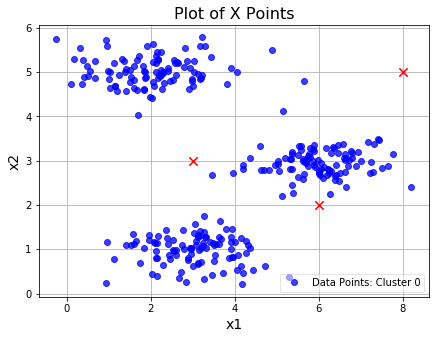

In [172]:
plotData(X, [initial_centroids])

In [173]:
# 两个点之间的距离(x1-x2)^2+(y1-y2)^2
def distSquared(point1, point2):
    assert point1.shape == point2.shape
    return np.sum(np.square(point2-point1))
    

In [174]:
def findCloestCentroids(myX, mycentroids):
    """
    Function takes in the (m,n) X matrix
    (where m is the No. of points, n is No. of features per point)
    and the (K,n) centroid seed matrix
    (where K is the No. of the centroids(clusters))
    and returns a (m,1) vector of cluster indices
    per point in X (0 through K-1)
    """
    idxs = np.zeros((myX.shape[0],1))
    
    # Loop through each data point in X
    for x in range(idxs.shape[0]):
        mypoint = myX[x]
        # compare this point to each centroid,
        # Keep track of shorteat distance and index of shortest distance
        minDist, idx = 999999, 0
        
        # 分别计算没个点到每个centorid的距离，然后将该点分到最近的那个centroid
        # idx -> i = [0, 1, 2]
        for i in range(mycentroids.shape[0]):
            mycentroid = mycentroids[i]
            distsquared = distSquared(mycentroid, mypoint)
            if distsquared < minDist:
                minDist = distsquared
                idx = i
                
        # with the best index found, modify the result idx vector
        idxs[x] = idx
        
    return idxs
    

In [175]:
idxs = findCloestCentroids(X, initial_centroids)

#you should see the output [1 3 2] corresponding to the 
#centroid assignments for the first 3 examples.
#Note my indices start at 0, so I should see [0, 2, 1]
print (idxs[:3].flatten())

[0. 2. 1.]


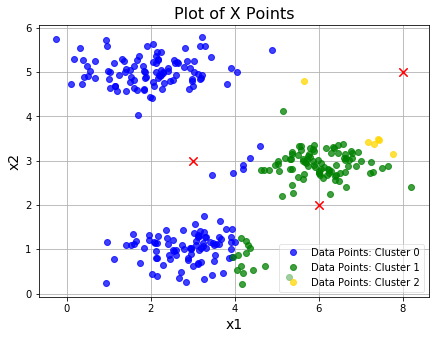

In [176]:
plotData(X,[initial_centroids],idxs)

#### 1.1.1 Computing centorid means

In [198]:
def computeCentroids(myX, myidxs):
    """
    Function takes in the X matrix and the index vector
    and compute a new centroid matrix（地址）
    """
    subX = []
    for x in range(len(np.unique(myidxs))):
        subX.append(np.array([myX[i] for i in range(myX.shape[0]) if myidxs[i]==x]))
#     print (subX)
    return np.array([np.mean(thisX, axis=0) for thisX in subX])
    

#### 1.2 K-means on example dataset

In [199]:
def runKMeans(myX, initial_centroids, K, n_iter):
    """
    Function that actually does the iterations
    """
    centroid_history = []
    current_centroids = initial_centroids
    for myiter in range(n_iter):
        centroid_history.append(current_centroids)
        idxs = findCloestCentroids(myX, current_centroids)
        current_centroids = computeCentroids(myX, idxs)
    
    return idxs, centroid_history
    

In [200]:
idxs, centroid_history = runKMeans(X, initial_centroids, K=3, n_iter=10)

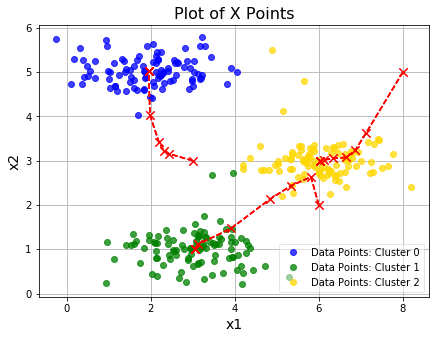

In [201]:
plotData(X, centroid_history, idxs)

#### 1.3 Random initialization 

In [208]:
def chooseKRandomCentroids(myX, K):
    # sample(range(0, myX.shape[0]), K) ->
    # 从0-myX.shape[0]，任意选取K个值
    rand_indices = sample(range(0, myX.shape[0]), K)
#     print (myX.shape[0], rand_indices)
    return np.array([myX[i] for i in rand_indices])

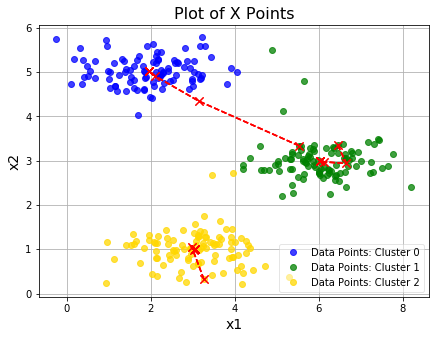

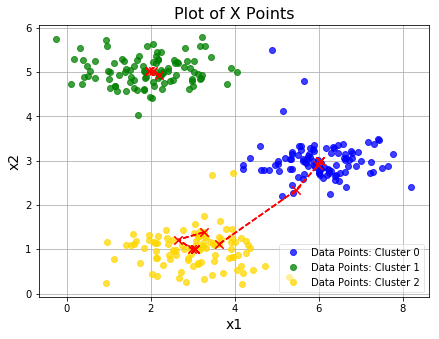

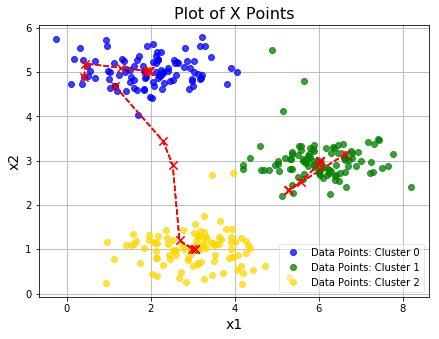

In [106]:
#Let's choose random initial centroids and see the resulting 
#centroid progression plot.. perhaps three times in a row

for x in range(3):
    idxs, centroid_history = runKMeans(X, chooseKRandomCentroids(X, K=3),
                                       K=3, n_iter=10)
    plotData(X, centroid_history, idxs)


#### 1.4 Image compression压缩 with K-means 

##### 1.4.1 K-means on pixels 

[[[219 180 103]
  [230 185 116]
  [226 186 110]
  ...
  [ 14  15  13]
  [ 13  15  12]
  [ 12  14  12]]

 [[230 193 119]
  [224 192 120]
  [226 192 124]
  ...
  [ 16  16  13]
  [ 14  15  10]
  [ 11  14   9]]

 [[228 191 123]
  [228 191 121]
  [220 185 118]
  ...
  [ 14  16  13]
  [ 13  13  11]
  [ 11  15  10]]

 ...

 [[ 15  18  16]
  [ 18  21  18]
  [ 18  19  16]
  ...
  [ 81  45  45]
  [ 70  43  35]
  [ 72  51  43]]

 [[ 16  17  17]
  [ 17  18  19]
  [ 20  19  20]
  ...
  [ 80  38  40]
  [ 68  39  40]
  [ 59  43  42]]

 [[ 15  19  19]
  [ 20  20  18]
  [ 18  19  17]
  ...
  [ 65  43  39]
  [ 58  37  38]
  [ 52  39  34]]]
A shape is  (128, 128, 3)


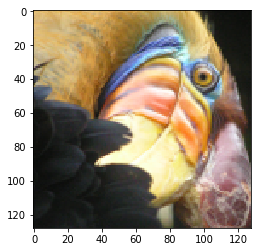

In [222]:
datafile = 'data/bird_small.png'
# This creates a three-dimensional matrix A whose first two indices 
# identify a pixel position and whose last index represents red, green, or blue.
# A = mpimg.imread(datafile)
A = imageio.imread(datafile)
print (A)

print ("A shape is ",A.shape)
dummy = plt.imshow(A)


In [215]:
# Divide every entry in A by 255 so all values are in the range of 0 to 1
A = A / 255.

# Unroll the image to shape (16384,3) (16384 = 128 * 128)
A = A.reshape(-1, 3)
print (A.shape)

# Run K-means on this data, forming 16 clusters, with random initialization
myK = 16
idxs, centroid_history = runKMeans(A, chooseKRandomCentroids(A, myK),
                                   myK, n_iter=10)


(16384, 3)
16384 [12764, 9668, 7716, 12888, 5493, 2766, 16178, 13129, 15143, 9710, 1585, 3323, 2201, 14058, 12252, 14789]


In [122]:
# Now I have 16 centroids, each representing a color.
# Let's assign an index to each pixel in the original image dictating支配
# which of the 16 colors it should be
idxs = findCloestCentroids(A, centroid_history[-1])

In [123]:
final_centroids = centroid_history[-1]
# Now loop through the original image and form a new image
# that only has 16 colors in it
final_iamge = np.zeros((idxs.shape[0], 3))
for x in range(final_iamge.shape[0]):
    final_iamge[x] = final_centroids[int(idxs[x])]


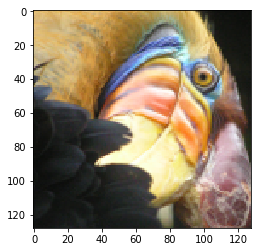

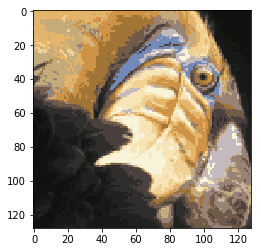

In [124]:
# Reshape the original image and the new, final image and drwa them
# To see what the "compressed" image looks like
plt.figure()
dummy = plt.imshow(A.reshape(128, 128, 3))
plt.figure()
dummy = plt.imshow(final_iamge.reshape(128, 128, 3))



### 2 Principal Component Analysis 

#### 2.1 Example Dataset

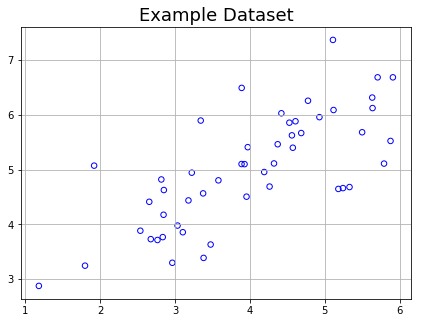

In [125]:
datafile = 'data/ex7data1.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']

#Quick plot
plt.figure(figsize=(7,5))
plot = plt.scatter(X[:,0], X[:,1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset",fontsize=18)
plt.grid(True)

#### 2.2 Implementing PCA

In [131]:
"""
Before using PCA, it is important to first normalize the data 
by subtract- ing the mean value of each feature from the dataset, 
and scaling each dimen- sion so that they are in the same range
"""

# 对列特征数据进行归一化处理
def featureNormalize(myX):
    # Feature-normalize X, return it
    means = np.mean(myX, axis=0)
    myX_norm = myX - means
    
    stds = np.std(myX_norm, axis=0)
    myX_norm = myX_norm / stds
    
    return means, stds, myX_norm


In [129]:
def getUSV(myX_norm):
    # Compute the convariance matrix
    # myX_norm.shape[0] -> m
    cov_matrix = myX_norm.T.dot(myX_norm) / myX_norm.shape[0]
    
    # Run single value decomposition分解 to get the U principal component matrix
    U, S, V = scipy.linalg.svd(cov_matrix, full_matrices=True, compute_uv=True)
    
    return U, S,V
    

In [226]:
# Feature normalize
means, stds, X_norm = featureNormalize(X)
# Run SVD
U, S, V = getUSV(X_norm)


Top principal component is  [-0.70710678 -0.70710678]


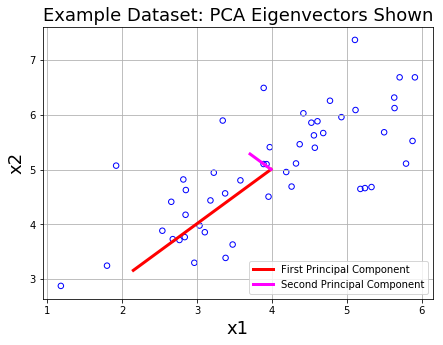

In [134]:
# "...output the top principal component (eigen- vector) found, 
# and you should expect to see an output of about [-0.707 -0.707]"
print ('Top principal component is ',U[:,0])

# Quick plot
plt.figure(figsize=(7,5))
plot = plt.scatter(X[:,0], X[:,1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset: PCA Eigenvectors Shown",fontsize=18)
plt.xlabel('x1',fontsize=18)
plt.ylabel('x2',fontsize=18)
plt.grid(True)

# To draw the principal component, you draw them starting 
# at the mean of the data
plt.plot([means[0], means[0] + 1.5*S[0]*U[0,0]], 
         [means[1], means[1] + 1.5*S[0]*U[0,1]],
        color='red',linewidth=3,
        label='First Principal Component')
plt.plot([means[0], means[0] + 1.5*S[1]*U[1,0]], 
         [means[1], means[1] + 1.5*S[1]*U[1,1]],
        color='fuchsia',linewidth=3,
        label='Second Principal Component')
leg = plt.legend(loc=4)



#### 2.3 Dimensinality Reduction with PCA

##### Projecting the data onto the principal component 

In [137]:
def projectData(myX, myU, K):
    """
    Function that computes the reduced data representation整理后的数据 when
    projecting展现 only onto the top "K" eigenvectors特征向量
    
    U => principal component PCA
    将x中的每个示例投影到U中的前k个组件上
    """
    # Reduced U is the first "K" columns in U
    Ureduced = myU[:, :K]
    z = myX.dot(Ureduced)
    return z
    

In [138]:
# "...project the first example onto the first dimension 
# "and you should see a value of about 1.481"
z = projectData(X_norm,U,1)
print ('Projection of the first example is %0.3f.'%float(z[0]))

Projection of the first example is 1.496.


##### 2.3.2 Reconstructing重建 an approximation近似值 of the data

In [139]:
def recoverData(myZ, myU, K):
    """
    approximately recover the data by projecting 
    them back onto the original high dimensional space.
    """
    Ureduced = myU[:, :K]
    Xapprox = myZ.dot(Ureduced.T)
    return Xapprox
    

In [143]:
X_rec = recoverData(z,U,1)
print ('Recovered approximation of the first example is ',X_rec[0])


Recovered approximation of the first example is  [-1.05805279 -1.05805279]


##### 2.2.3 Visualizing the projections

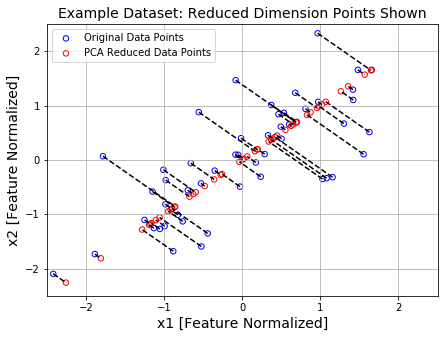

In [147]:
# quick plot, drawing projected points to the original points
plt.figure(figsize=(7,5))
# original points 原始点
plot = plt.scatter(X_norm[:,0], X_norm[:,1], s=30, facecolors='none', 
                   edgecolors='b',label='Original Data Points')
# projected points 映射后的点
plot = plt.scatter(X_rec[:,0], X_rec[:,1], s=30, facecolors='none', 
                   edgecolors='r',label='PCA Reduced Data Points')

plt.title("Example Dataset: Reduced Dimension Points Shown",fontsize=14)
plt.xlabel('x1 [Feature Normalized]',fontsize=14)
plt.ylabel('x2 [Feature Normalized]',fontsize=14)
plt.grid(True)

for x in range(X_norm.shape[0]):
    plt.plot([X_norm[x,0], X_rec[x,0]], [X_norm[x,1], X_rec[x,1]], 'k--')
    
leg = plt.legend()

# Force square axes to make projections look better
# 设置一个方形的区间
dummy = plt.xlim((-2.5,2.5))
dummy = plt.ylim((-2.5,2.5))
    


##### 2.4 Face Image Dataset

In [148]:
datafile = 'data/ex7faces.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']

In [153]:
def getDatumImg(row):
    """
    Function that is handed a single np.array with shape 1x1032,
    creates an image object from it, and returns it
    获取图片
    """
    
    width, height = 32, 32
    square = row.reshape(width, height) # 将big_image转成方形
    return square.T
    

In [155]:
def displayData(myX, mynrows=10, myncols=10):
    """
    Function that picks the first 100 rows from X,
    creates an image from each,
    then stitches them together into a 10x10 grid of image, 
    and shows it
    """
    
    width, height = 32, 32
    nrows, ncols = mynrows, myncols # 每行每列显示几个image
    
    big_picture = np.zeros((height*nrows, width*ncols))
    
    irow, icol = 0, 0
    for idx in range(nrows*ncols): # 便利所有的图片
        if icol == ncols: # 换行
            irow += 1
            icol  = 0
        iimg = getDatumImg(myX[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    
    fig = plt.figure(figsize=(10,10))
    img = Image.fromarray(big_picture)
    plt.imshow(img, cmap=cm.Greys_r)
    

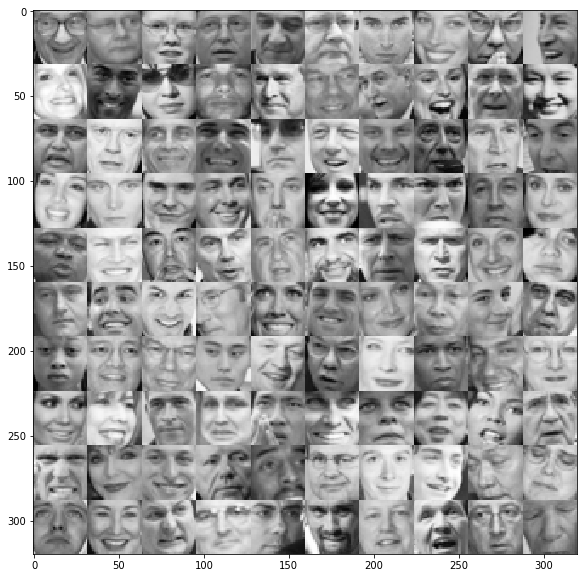

In [156]:
displayData(X)

##### 2.4.1 PCA on Faces

In [157]:
# Feature normalize
means, stds, X_norm = featureNormalize(X)
# Run SVD
U, S, V = getUSV(X_norm)

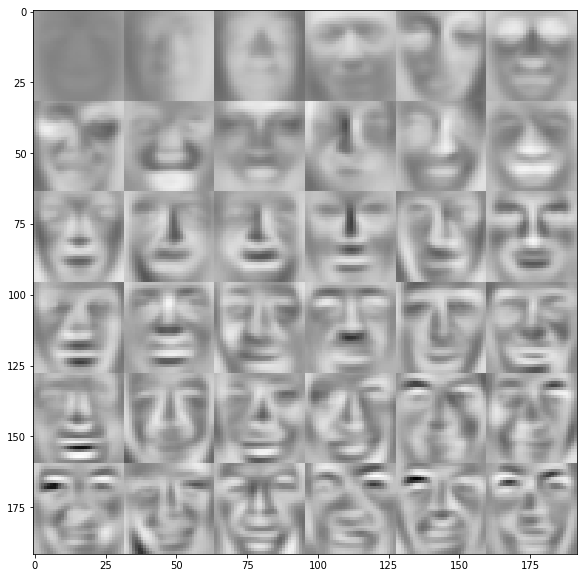

In [158]:
# Visualize the top 36 eigenvectorsr特征向量 found
displayData(U[:, :36].T, mynrows=6, myncols=6)

In [159]:
a = np.array([1,2,3])
print (a.shape[0])

3
